Running on local URL:  http://127.0.0.1:7914
Running on public URL: https://5951b1b0fcd28826.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://www.huggingface.co/spaces


(<gradio.routes.App at 0x199f7427850>,
 'http://127.0.0.1:7914/',
 'https://5951b1b0fcd28826.gradio.app')

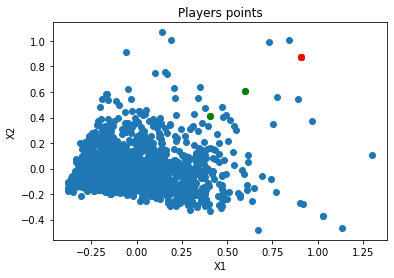

0.7203132653975706 0.0 1.663930159976544
          cosine  euclidean  mahalanobis  minkowski  sqeuclidean
0     100.000000   0.000000     0.000000   0.000000     0.000000
1      90.708239   0.432899     0.432899   0.432899     0.187401
2      91.512665   0.610024     0.610024   0.610024     0.372129
3      71.904502   0.711973     0.711973   0.711973     0.506906
4      98.978665   0.146675     0.146675   0.146675     0.021514
...          ...        ...          ...        ...          ...
1330   83.393447   0.689957     0.689957   0.689957     0.476041
1331   95.663021   0.796532     0.796532   0.796532     0.634464
1332   91.482038   0.878073     0.878073   0.878073     0.771012
1333   90.558409   0.696880     0.696880   0.696880     0.485642
1334   82.121021   0.893146     0.893146   0.893146     0.797710

[1335 rows x 5 columns]
True


In [167]:
import gradio as gr
from joblib import load
import numpy as np
from scipy import spatial
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

solo = load('data/solo.joblib')
duo = load('data/duo.joblib')
trio = load('data/trio.joblib')
squad = load('data/squad.joblib')
users = load('data/users.joblib')

def plotOnMap(p1, Players, userList):
    pca = PCA(n_components = 2)
    playersPCA = pca.fit_transform(Players)
    p1PCA = pca.transform([p1])
    userListPCA = pca.transform(userList)
    
    fig = plt.figure()
    
    plt.scatter(playersPCA[:, 0], playersPCA[:, 1])
    plt.scatter(userListPCA[:, 0], userListPCA[:, 1], c = 'g')
    plt.scatter(p1PCA[:, 0], p1PCA[:, 1], c = 'r')

    plt.title("Players points")
    plt.ylabel("X2")
    plt.xlabel("X1")
    return fig

def standard(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    #return X

def bigModel(p1, Players):
    cosine = []
    euclidean = []
    mahalanobis = []
    minkowski = []
    sqeuclidean = []
    
    m = np.identity(7)
    
    for p2 in Players:
            cosine.append((1 - spatial.distance.cosine(p1, p2))*100)
        euclidean.append(spatial.distance.euclidean(p1, p2))
        mahalanobis.append(spatial.distance.mahalanobis(p1, p2, m))
        minkowski.append(spatial.distance.minkowski(p1, p2))
        sqeuclidean.append(spatial.distance.sqeuclidean(p1, p2))
    
    print(euclidean[1], np.array(euclidean).min(axis=0), np.array(euclidean).max(axis=0))
    
    euclidean = standard(np.array(euclidean))
    mahalanobis = standard(np.array(mahalanobis))
    minkowski = standard(np.array(minkowski))
    sqeuclidean = standard(np.array(sqeuclidean))
    
    df_scores = pd.DataFrame(data=np.array([
        cosine, 
        euclidean,
        mahalanobis,
        minkowski,
        sqeuclidean
    ]).T, columns = [
        "cosine", 
        "euclidean",
        "mahalanobis",
        "minkowski",
        "sqeuclidean"
    ])
    
    print(df_scores)
    
    return True
    
def prediction(p1, Players, n):
    df_players = pd.DataFrame(data=Players, columns=["score", "top1", "kd", "winRatio", "matches", "kills", "minutes"])

    df_scores = bigModel(p1, Players)
    print(df_scores)
    
    Distances = []
    for p2 in Players:
        Distances.append((1 - spatial.distance.cosine(p1, p2))*100)
    
    df_players.insert(1, "Matching %", Distances)
    df_players = df_players.sort_values(by=['Matching %'], ascending=False)

    userIndexes = df_players.head(n).index
    userList = users[userIndexes]
    matchingPlayers = Players[userIndexes]

    fig = plotOnMap(p1,Players, matchingPlayers)

    return userList, fig

def printPlayers(players):
    label = "Matching players:\n"
    for player in players:
        label += f"\n{player[0]}"
    return label

def greet(type, score, top1, kd, winRatio, matches, kills, minutes):
    p1 = np.array([score, top1, kd, winRatio, matches, kills, minutes])

    if type == 'Solo': userList, fig = prediction(p1, solo, 1)
    if type == 'Duo': userList, fig = prediction(p1, duo, 3)
    if type == 'Trio': userList, fig =  prediction(p1, trio, 5)
    if type == 'Squad': userList, fig =  prediction(p1, squad, 7)

    userList = printPlayers(userList)

    return userList, fig

demo = gr.Interface(
    fn=greet,
    examples = [
        ["Duo", 0.730117966,0.735317356,0.763649425,0.81316726,0.264922696,0.496196684,0.492858304],
    ],
    inputs=[
        gr.Dropdown(["Solo", "Duo", "Trio", "Squad"]),
        "number", 
        "number", 
        "number", 
        "number", 
        "number", 
        "number", 
        "number"
    ],
    outputs=[gr.Text(label= "Similar"), gr.Plot()]
)

demo.launch(share=True)

In [8]:
users

array([['Prospеring'],
       ['BH nixxxay'],
       ['Raпger'],
       ...,
       ['Noel Brabo do AM'],
       ['ouver 67'],
       ['FireDrâgon']], dtype=object)

In [33]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')
dist.pairwise(examples)

array([[0.       , 1.1846739],
       [1.1846739, 0.       ]])

In [27]:
examples = [[0.730117966,0.735317356,0.763649425,0.81316726,0.264922696,0.496196684,0.492858304], [0.827088116,0.296154859,0.067528736,0.163701068,0.528823363,0.156766414,0.824428073]]

examples

[[0.730117966,
  0.735317356,
  0.763649425,
  0.81316726,
  0.264922696,
  0.496196684,
  0.492858304],
 [0.827088116,
  0.296154859,
  0.067528736,
  0.163701068,
  0.528823363,
  0.156766414,
  0.824428073]]

In [79]:
spatial.distance.cosine(examples[0], examples[1])

0.2809549750635626

In [80]:
spatial.distance.euclidean(examples[0], examples[1])

1.1846738956004492

In [87]:
spatial.distance.mahalanobis(examples[0], examples[1], np.identity(len(examples[0])))

1.1846738956004494

In [82]:
spatial.distance.minkowski(examples[0], examples[1])

1.1846738956004492

In [88]:
spatial.distance.sqeuclidean(examples[0], examples[1])

1.4034522389171444

In [105]:
X = np.array([0, 2, 1, 1, 1.23])

In [106]:
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
#X_scaled = X_std * (max - min) + min

In [107]:
X_std

array([0.   , 1.   , 0.5  , 0.5  , 0.615])

In [116]:
X_temp = np.array([X, X])

In [118]:
X_temp.T

array([[0.  , 0.  ],
       [2.  , 2.  ],
       [1.  , 1.  ],
       [1.  , 1.  ],
       [1.23, 1.23]])